In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os, os.path
CAFFE_ROOT_DIR = '/mnt/ilcompf0d0/user/xliu/code/caffe/'
sys.path.append(os.path.join(CAFFE_ROOT_DIR, 'python'))
import caffe
from caffe.io import caffe_pb2
import py_data_layers
import numpy as np

from numpy import linalg as LA

In [2]:
solver_dir = os.path.join(CAFFE_ROOT_DIR, 'examples/distilling/siamese_project')
os.chdir(solver_dir)
caffe.set_mode_gpu()
caffe.set_device(0)

In [3]:
solver = caffe.SGDSolver( os.path.join(solver_dir, 'solver.prototxt') )

print [[k] for k, v in solver.net.params.items()]

Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [48.6592769623 second]
Total number of samples pre-loaded: 1370918
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.32359313965 second]
Total number of samples pre-loaded: 54592
[['conv1'], ['conv2'], ['conv3'], ['conv4'], ['conv5'], ['fc6'], ['fc7'], ['feat'], ['conv1_p'], ['conv2_p'], ['conv3_p'], ['conv4_p'], ['conv5_p'], ['fc6_p'], ['fc7_p'], ['feat_p']]


## How the netowrk is trained?
Run training for 200 iterations, and plot training loss, L2 distance of both positive pairs and negative pairs respectively

In [ ]:
batch_size = 128
iteration_count = 100
loss = np.zeros((iteration_count, ))
positive_l2_dist = np.zeros((iteration_count, ))
negative_l2_dist = np.zeros((iteration_count, ))

for i in range(iteration_count):
    solver.step(1)
    iter_loss = solver.net.blobs['loss'].data
    print "Iteration {}: loss = {}".format(i, iter_loss)
    loss[i] = iter_loss[...]
    feat = solver.net.blobs['feat_norm'].data
    feat_p = solver.net.blobs['feat_norm_p'].data
    positive_error = 0
    negative_error = 0
    for j in range(batch_size / 2):
        positive_idx = j*2
        negative_idx = j*2 + 1
        positive_error += LA.norm(feat[positive_idx,...] - feat_p[positive_idx,...])
        negative_error += LA.norm(feat[negative_idx,...] - feat_p[negative_idx,...])
    positive_l2_dist[i] = positive_error / batch_size * 2
    negative_l2_dist[i] = negative_error / batch_size * 2

**Plot loss and errors**

loss at iteration 200= 0.0938984379172


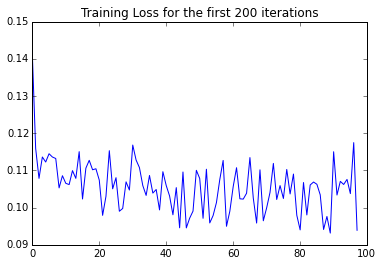

In [5]:
plt.clf()
plt.plot(loss[2:])
plt.title('Training Loss for the first 200 iterations')
print "loss at iteration 200=", loss[-1]

average distance at iteration 200= 0.393850696972


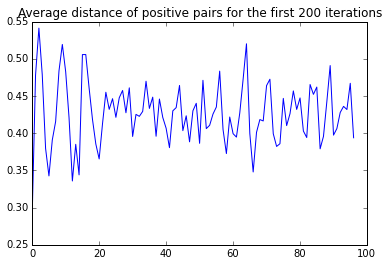

In [6]:
plt.clf()
plt.plot(positive_l2_dist[3:])
plt.title('Average distance of positive pairs for the first 200 iterations')
print "average distance at iteration 200=", positive_l2_dist[-1]

average distance at iteration 200= 0.586389308795


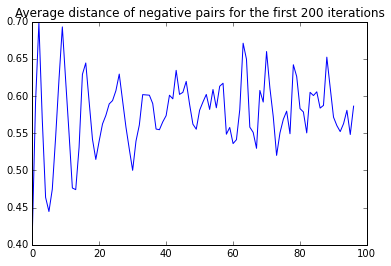

In [7]:
plt.clf()
plt.plot(negative_l2_dist[3:])
plt.title('Average distance of negative pairs for the first 200 iterations')
print "average distance at iteration 200=", negative_l2_dist[-1]

### Plot the difference between positive pairs and negative pairs 

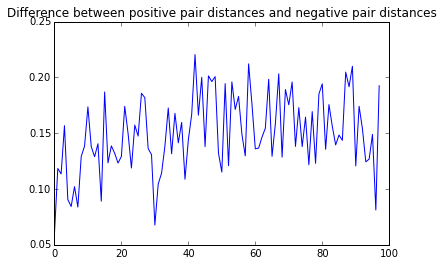

In [8]:
dist_diff = negative_l2_dist - positive_l2_dist
plt.clf()
plt.plot(dist_diff[2:])
plt.title('Difference between positive pair distances and negative pair distances')

## Visualize filters of trained model

In [3]:
def get_net(network_fn, model_fn, mode='CPU'):
    if mode == 'CPU':
        caffe.set_mode_cpu()
    else:
        caffe.set_mode_gpu()
    net = caffe.Net(network_fn, model_fn,
                    caffe.TEST)
    return net

def vis_square(data, figure_fn=None, padsize=1, padval=0, color_map='gray'):
    data -= data.min()
    data /= data.max()
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    imgplot = plt.imshow(data)
    # set colormap, only for single channel images
    if data.ndim == 2:
        imgplot.set_cmap(color_map)
    if figure_fn is None:
        plt.show()
    else:
        plt.savefig(figure_fn)

def visualize_network_filter(network_fn, model_fn, base_dir='./', figure_fn=None, layer='conv1'):
    os.chdir(base_dir)
    print 'Chaning to dir = {}'.format(base_dir)
    net = get_net(network_fn, model_fn)
    plt.clf()
    if layer not in net.params.keys():
        print "Wrong Layer Name: {}".format(layer)
        return
    filters = net.params[layer][0].data
    #vis_square(filters.transpose(0,2,3,1), figure_fn)
    if filters.shape[1] == 3:
        vis_square(filters.transpose(0,2,3,1), figure_fn)
    else:
        filters = filters[:, 0:3, :, :]
        # filters = filters.reshape((filters.shape[0] * filters.shape[1], 1, filters.shape[2], filters.shape[3]))
        vis_square(filters.transpose(0,2,3,1), figure_fn)

### Visualize the filter of trained siamese net at 200 iterations

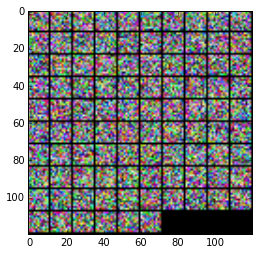

In [13]:
filters = solver.net.params['conv1'][0].data
vis_square(filters.transpose(0,2,3,1))

### Visualize the filter of trained siamese net at certain iterations

In [27]:
network_fn = 'train_val.prototxt'
model_fn = 'siamese_project_iter_16000.caffemodel'

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.65802598 second]
Total number of samples pre-loaded: 54592


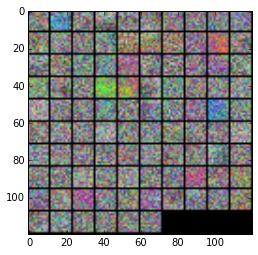

In [28]:
visualize_network_filter(network_fn, model_fn)

### How about distance of positive pairs and negative pairs at current network state?

In [195]:
caffe.set_mode_gpu()
caffe.set_device(0)
# reading net and weights
net = caffe.Net(network_fn, model_fn, caffe.TEST)
batch_size = 128

Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.21128487587 second]
Total number of samples pre-loaded: 54592


In [209]:
net.forward()
feat = net.blobs['feat_norm'].data
feat_p = net.blobs['feat_norm_p'].data
print feat.shape
print feat_p.shape

(128, 256, 1, 1)
(128, 256, 1, 1)


In [210]:
dist = [LA.norm(feat[i, ...]-feat_p[i,...]) for i in range(batch_size)]
positive_dist = np.array([dist[2*i] for i in range(batch_size / 2)])
negative_dist = np.array([dist[2*i + 1] for i in range(batch_size / 2)])
difference = negative_dist - positive_dist

0.331482


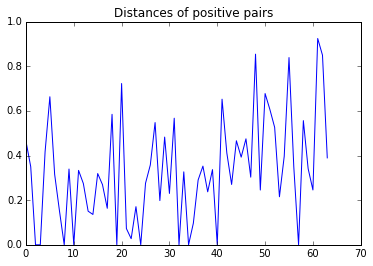

In [211]:
plt.clf()
plt.plot(positive_dist)
plt.title('Distances of positive pairs')
print np.average(positive_dist)

0.609923


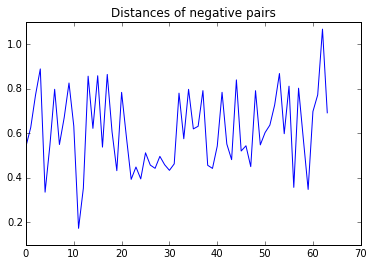

In [212]:
plt.clf()
plt.plot(negative_dist)
plt.title('Distances of negative pairs')
print np.average(negative_dist)

0.278441


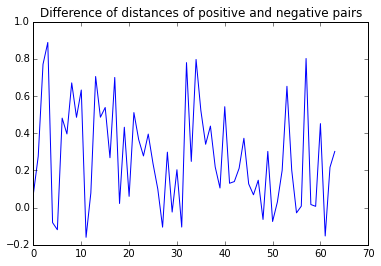

In [213]:
plt.clf()
plt.plot(difference)
plt.title('Difference of distances of positive and negative pairs')
print np.average(difference)

### What are those "hard samples", either positive or negative?

In [214]:
data = net.blobs['data'].data
data_p = net.blobs['data_p'].data

In [215]:
def transform_img(img):
    img = img.transpose(1,2,0)
    img = img[:,:,::-1]
    return img

def add_mean(img, image_mean):
    if image_mean.ndim == 1:
        image_mean = image_mean[:, np.newaxis, np.newaxis]
    img += image_mean
    return img

[48 55 61 62]


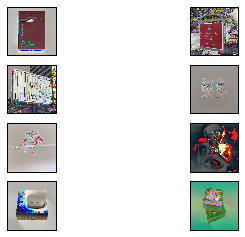

In [218]:
# find some most difficult hard positive pairs
hard_positive = np.where(positive_dist > 0.8)[0]
print hard_positive
hard_positive_count = hard_positive.size
# create subplotting
plt.clf()
f, axarr = plt.subplots(hard_positive_count, 2)
for idx in range(hard_positive_count):
    img_id = hard_positive[idx] * 2
    anchor = data[img_id, ...]
    anchor = transform_img(anchor)
    positive_img = data_p[img_id, ...]
    positive_img = transform_img(positive_img)
    axarr[idx, 0].imshow(anchor)
    axarr[idx, 1].imshow(positive_img)
    axarr[idx, 0].axes.get_xaxis().set_visible(False)
    axarr[idx, 0].axes.get_yaxis().set_visible(False)
    axarr[idx, 1].axes.get_xaxis().set_visible(False)
    axarr[idx, 1].axes.get_yaxis().set_visible(False)

<type 'numpy.int64'>


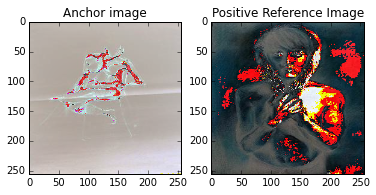

In [219]:
hard_positive = np.argmax(positive_dist)
print type(hard_positive)
plt.clf()
f, axarr = plt.subplots(1, 2)
img_id = hard_positive * 2
anchor = data[img_id, ...]
anchor = transform_img(anchor)
positive_img = data_p[img_id, ...]
positive_img = transform_img(positive_img)
axarr[0].imshow(anchor)
axarr[0].set_title('Anchor image')
axarr[1].imshow(positive_img)
axarr[1].set_title('Positive Reference Image')

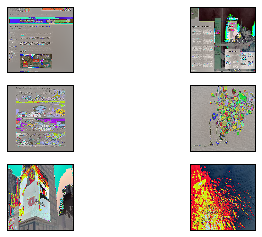

In [229]:
# find some hard negative pairs
hard_negative = np.where(negative_dist < 0.35)[0]
hard_negative_count = hard_negative.size
# create subplotting
plt.clf()
f, axarr = plt.subplots(hard_negative_count, 2)
for idx in range(hard_negative_count):
    img_id = hard_negative[idx] * 2 + 1
    anchor = data[img_id, ...]
    anchor = transform_img(anchor)
    negative_img = data_p[img_id, ...]
    negative_img = transform_img(negative_img)
    axarr[idx, 0].imshow(anchor)
    axarr[idx, 1].imshow(negative_img)
    axarr[idx, 0].axes.get_xaxis().set_visible(False)
    axarr[idx, 0].axes.get_yaxis().set_visible(False)
    axarr[idx, 1].axes.get_xaxis().set_visible(False)
    axarr[idx, 1].axes.get_yaxis().set_visible(False)

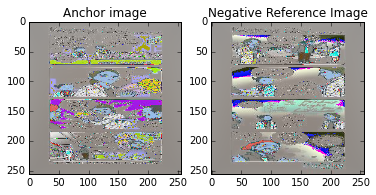

In [222]:
hard_negative = np.argmin(negative_dist)
plt.clf()
f, axarr = plt.subplots(1, 2)
img_id = hard_negative * 2
anchor = data[img_id, ...]
anchor = transform_img(anchor)
negative_img = data_p[img_id, ...]
negative_img = transform_img(negative_img)
axarr[0].imshow(anchor)
axarr[0].set_title('Anchor image')
axarr[1].imshow(negative_img)
axarr[1].set_title('Negative Reference Image')

**The False triplets:**

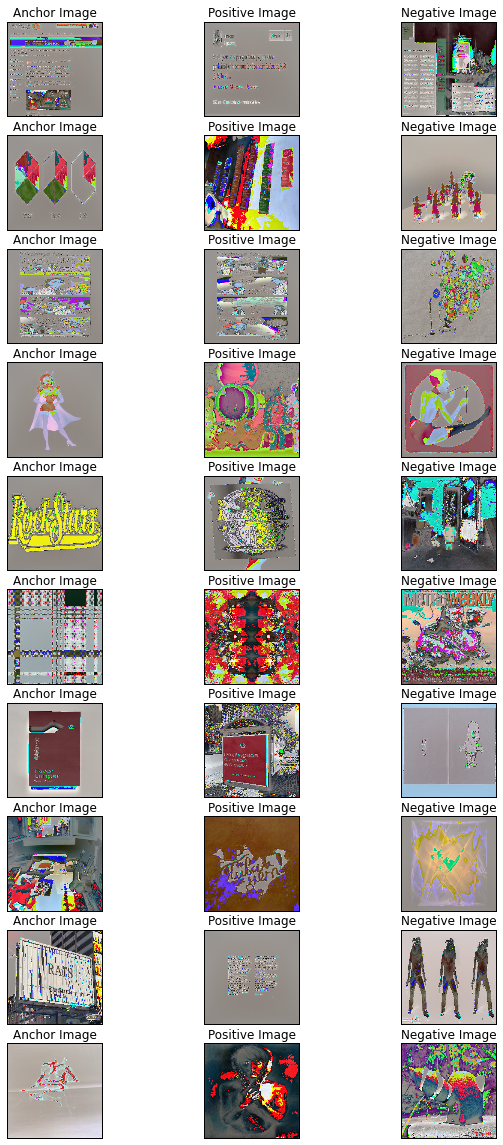

In [223]:
false_triplets = np.where(difference < 0)[0]
false_triplets_count = false_triplets.size
plt.clf()
f, axarr = plt.subplots(false_triplets_count, 3)
f.set_size_inches(10, 20)
for idx in range(false_triplets_count):
    image_id = false_triplets[idx]*2
    positive_id = image_id
    negative_id = image_id + 1
    anchor = data[image_id, ...]
    anchor = transform_img(anchor)
    positive_img = data_p[positive_id, ...]
    positive_img = transform_img(positive_img)
    negative_img = data_p[negative_id,...]
    negative_img = transform_img(negative_img)
    axarr[idx, 0].imshow(anchor)
    axarr[idx, 0].set_title('Anchor Image')
    axarr[idx, 0].axes.get_xaxis().set_visible(False)
    axarr[idx, 0].axes.get_yaxis().set_visible(False)
    axarr[idx, 1].imshow(positive_img)
    axarr[idx, 1].set_title('Positive Image')
    axarr[idx, 1].axes.get_xaxis().set_visible(False)
    axarr[idx, 1].axes.get_yaxis().set_visible(False)
    axarr[idx, 2].imshow(negative_img)
    axarr[idx, 2].set_title('Negative Image')
    axarr[idx, 2].axes.get_xaxis().set_visible(False)
    axarr[idx, 2].axes.get_yaxis().set_visible(False)

**Seeing the Gradient**

In [226]:
#performing backward
net.backward()
#get the gradient
conv1_gradient = net.params['conv1'][0].diff

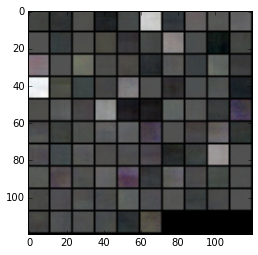

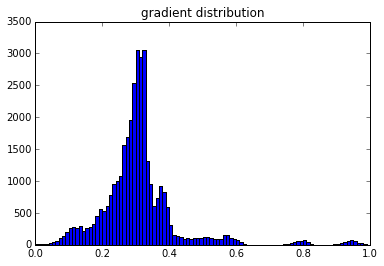

In [250]:
vis_square(conv1_gradient.transpose(0,2,3,1))
#print "Gradient range: {} to {}".format(conv1_gradient.flatten().min(), conv1_gradient.flatten().max())
n, bins, patches = plt.hist(conv1_gradient.flatten(), bins=100)
plt.title('gradient distribution')
plt.show()

** How about changing the learning rate?**

Here, changes the learning rate from 0.01 to 0.05
It turns out totally dis-ordered

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.49529886246 second]
Total number of samples pre-loaded: 54592


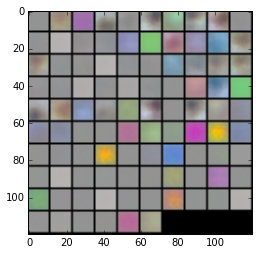

In [25]:
network_fn = 'train_val.prototxt'
model_fn = 'siamese_project_1_iter_17000.caffemodel'
visualize_network_filter(network_fn, model_fn)

**Using Fully Convolutional Neural Network**

This is supposed to reduce the potential of over-fitting. 3 fully connected layers are too complex to pass gradient to lower layers.

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.05699801445 second]
Total number of samples pre-loaded: 54592


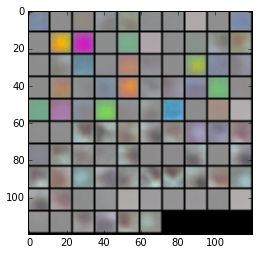

In [30]:
network_fn = 'train_val_conv.prototxt'
model_fn = 'siamese_project_3_iter_20000.caffemodel'
visualize_network_filter(network_fn, model_fn)

**So, how about the feature map and output?**

- Look at the gradient at the first convolutional layer, 
- The output feature map of convolutional layer 1, 
- The output of convolutional layer 2

In [18]:
net = get_net(network_fn, model_fn)

Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.89420700073 second]
Total number of samples pre-loaded: 54592


In [19]:
# run a step, and see feature map, gradient
output = net.forward()
net.backward()

{}

In [20]:
feat_map = net.blobs['conv1'].data[5,...]
conv1_gradient = net.params['conv1'][0].diff
print feat_map.shape
print conv1_gradient.shape

(96, 62, 62)
(96, 3, 11, 11)


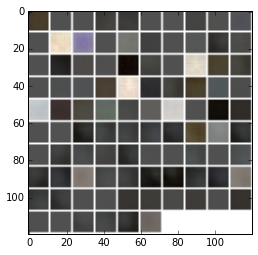

In [42]:
# plot gradient
vis_square(conv1_gradient.transpose(0, 2, 3, 1), padval=1)

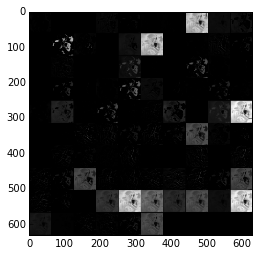

In [21]:
# plot feature map of first convolutional layer, for the first image
vis_square(feat_map)

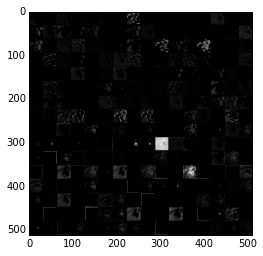

In [22]:
feat_map_conv2 = net.blobs['conv2'].data[5,...]
vis_square(feat_map_conv2)

** How about Changing network structure?**

Removing LRN layer, using only two fully connected layer, and remain learning-rate = 0.01

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.26337718964 second]
Total number of samples pre-loaded: 54592


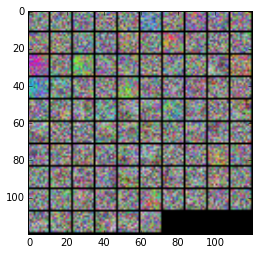

In [194]:
network_fn = 'train_val_2.prototxt'
model_fn = 'siamese_project_2_iter_8000.caffemodel'
visualize_network_filter(network_fn, model_fn)

### To-Do: Using ImageNet weights to calculate loss

Alexnet: use alexnet_train_val.prototxt

In [3]:
network_fn = './alexnet_train_val.prototxt'
model_fn = '../../../models/bvlc_alexnet/bvlc_alexnet.caffemodel'
net = caffe.Net(network_fn, model_fn, caffe.TEST)
print [(k, v.data.shape) for k, v in net.blobs.items()]

Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [12.3813078403 second]
Total number of samples pre-loaded: 54592
[('pair_data', (128, 6, 227, 227)), ('sim', (128, 1, 1, 1)), ('data', (128, 3, 227, 227)), ('data_p', (128, 3, 227, 227)), ('conv1', (128, 96, 55, 55)), ('norm1', (128, 96, 55, 55)), ('pool1', (128, 96, 27, 27)), ('conv2', (128, 256, 27, 27)), ('norm2', (128, 256, 27, 27)), ('pool2', (128, 256, 13, 13)), ('conv3', (128, 384, 13, 13)), ('conv4', (128, 384, 13, 13)), ('conv5', (128, 256, 13, 13)), ('pool5', (128, 256, 6, 6)), ('fc6', (128, 4096)), ('fc7', (128, 4096)), ('feat', (128, 1000)), ('feat_norm', (128, 1000, 1, 1)), ('conv1_p', (128, 96, 55, 55)), ('norm1_p', (128, 96, 55, 55)), ('pool1_p', (128, 96, 27, 27)), ('conv2_p', (128, 256, 27, 27)), ('norm2_p', (128, 256, 27, 27)), ('pool2_p', (128, 256, 13, 13)), ('conv3_p', (128, 384, 13, 13)), ('conv4_p', (128, 3

In [19]:
iteration_num = 100
alexnet_loss = np.zeros((iteration_num, ))
for i in range(iteration_num):
    output = net.forward()
    alexnet_loss[i] = output['loss']
print 'Averaged loss calculated using alexnet = {}'.format(np.average(alexnet_loss))

Averaged loss calculated using alexnet = 0.144562374949


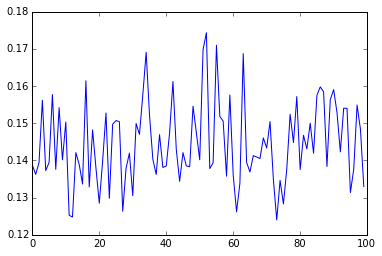

In [23]:
plt.clf()
plt.plot(alexnet_loss)

## New Experiments

Now I'm running an experiment on ilcomp43 tmux session train_1
- Model prototxt: train_val_conv_r.prototxt
- solver: solver_1.prototxt
- log: train_1.log
- layers: conv1 is copied from pretrained model, from conv2_r to conv6_r will be retrained.

----
Details: only conv1 is initialized using alexnet weights (from models/bvlc_alexnet/bvlc_alexnet.caffemodel)

In [4]:
model_fn = 'siamese_project_conv_r1_iter_20000.caffemodel'
network_fn = 'train_val_conv_r.prototxt'

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.55618214607 second]
Total number of samples pre-loaded: 54592


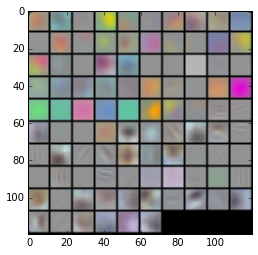

In [5]:
visualize_network_filter(network_fn, model_fn)

In [8]:
net = get_net(network_fn, model_fn)

Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [2.1353559494 second]
Total number of samples pre-loaded: 54592


In [12]:
output = net.forward()
net.backward()

{}

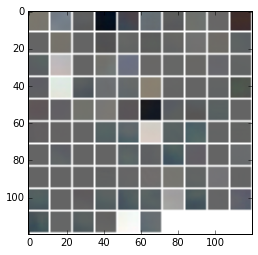

In [13]:
conv1_gradient = net.params['conv1'][0].diff
vis_square(conv1_gradient.transpose(0, 2, 3, 1), padval=1)

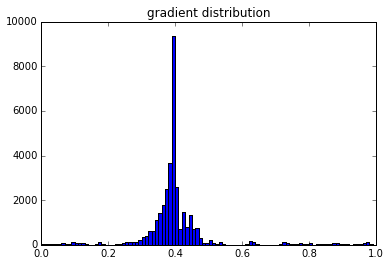

In [14]:
n, bins, patches = plt.hist(conv1_gradient.flatten(), bins=100)
plt.title('gradient distribution')
plt.show()

### Plot training and testig loss

In [6]:
# first, parse training log
! python ../parse_log.py log.log ./

In [ ]:
import csv
train_loss = []
training_log_fn = './log.log.train'
testing_log_fn = './log.log.test'
with open('log.log.train', 'rb') as csvfile:
    train_loss_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in train_los_reader:
        

### Initialization using Conv1 - Conv5

In [9]:
# model_fn = 'siamese_project_conv_alexnet_conv5_iter_10000.caffemodel'
network_fn = './train_val_conv_alexnet_conv5.prototxt'

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [2.26120996475 second]
Total number of samples pre-loaded: 54592


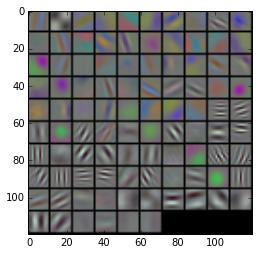

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [2.16760706902 second]
Total number of samples pre-loaded: 54592


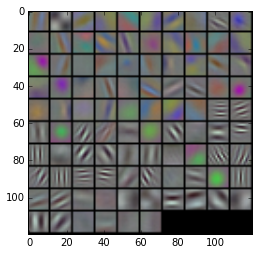

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.40850687027 second]
Total number of samples pre-loaded: 54592


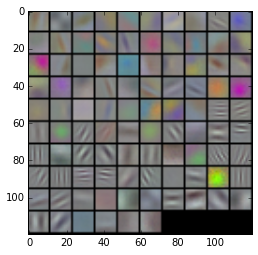

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [2.43793702126 second]
Total number of samples pre-loaded: 54592


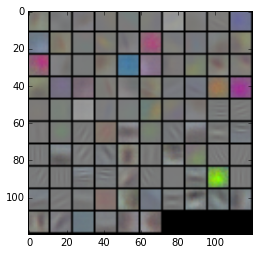

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [2.83328604698 second]
Total number of samples pre-loaded: 54592


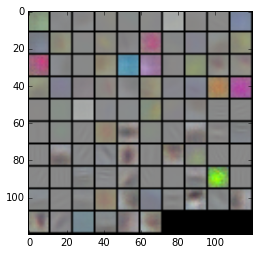

In [11]:
visualize_iterations = [1000,2000,5000,8000,10000]
for iteration in visualize_iterations:
    model_fn = "siamese_project_conv_alexnet_conv5_iter_{}.caffemodel".format(iteration)
    visualize_network_filter(network_fn, model_fn)

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.71768379211 second]
Total number of samples pre-loaded: 54592


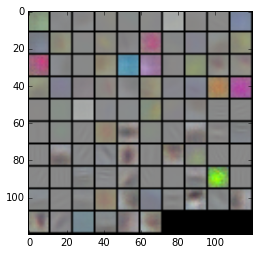

In [10]:
visualize_network_filter(network_fn, model_fn)

### Random Flip

With prob = 0.1

In [20]:
model_fn = 'siamese_project_conv_flip_iter_12000.caffemodel'
network_fn = './train_val_conv_flip.prototxt'

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = SiameseDataLayer]
Preloading data from LMDB...
[SiameseDataLayer]: Preloading image data done [1.29015183449 second]
Total number of samples pre-loaded: 54592


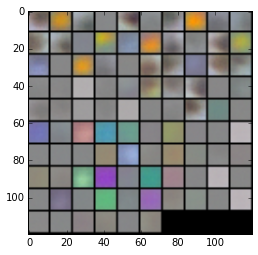

In [21]:
visualize_network_filter(network_fn, model_fn)